Model Accuracy: 96.25%
Classification Report:
              precision    recall  f1-score   support

       Risky       0.99      0.92      0.96       993
    Moderate       0.96      0.99      0.98      2738
        Good       0.88      0.84      0.86       316
   Excellent       0.98      0.96      0.97       517

    accuracy                           0.96      4564
   macro avg       0.95      0.93      0.94      4564
weighted avg       0.96      0.96      0.96      4564



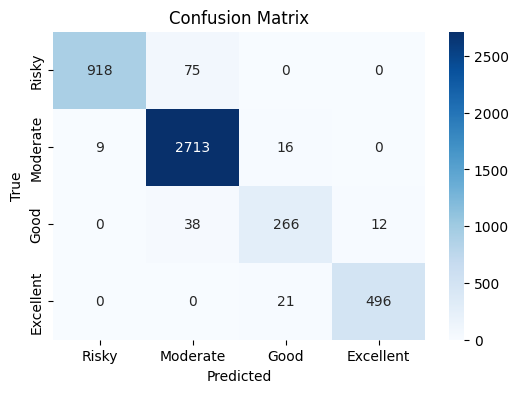

C:\Users\anush\AppData\Local\Temp\ipykernel_31892\298846866.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


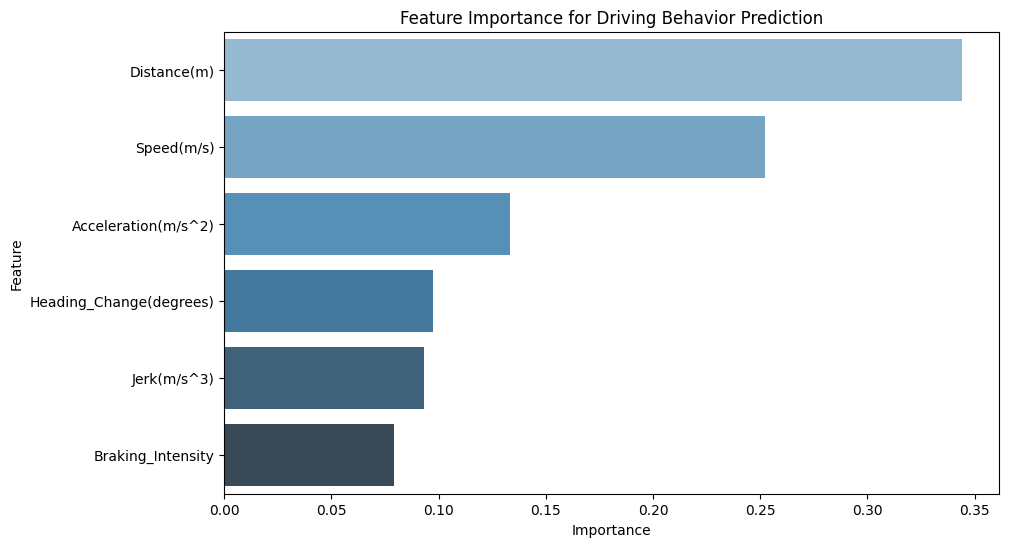

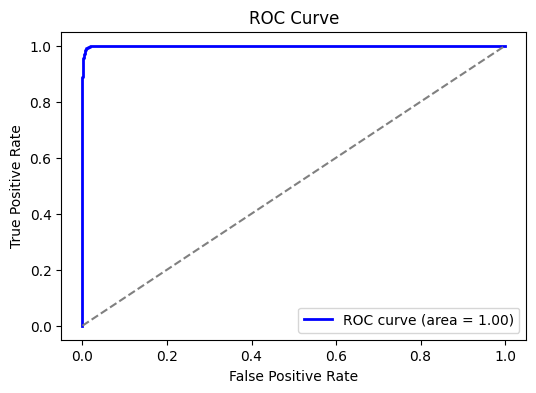

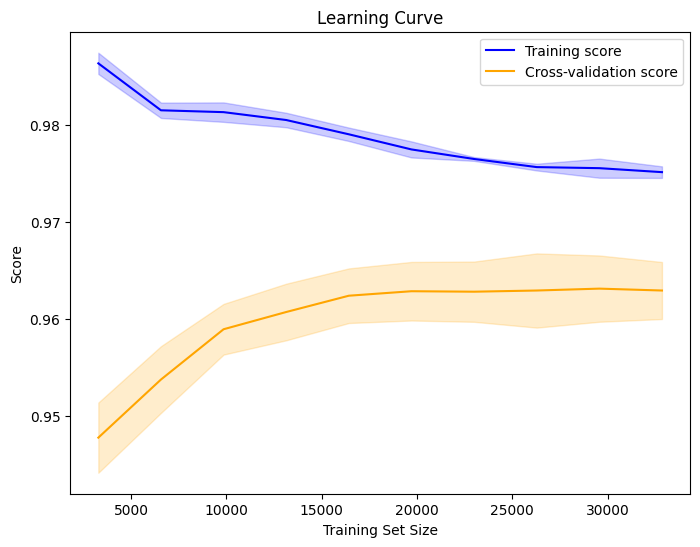

Model saved to models/driving_behavior_model.pkl


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Ensure the 'models' directory exists
model_directory = 'models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Load the processed data
df = pd.read_csv('data/processed_data.csv')

# Feature Selection: Using relevant features for ML training
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity', 'Distance(m)']]
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Good': 2, 'Excellent': 3})  # Convert driving categories to numeric labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Good', 'Excellent']))

### Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Good', 'Excellent'], yticklabels=['Risky', 'Moderate', 'Good', 'Excellent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance Plot
# Get feature importance from the RandomForest model
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Feature Importance for Driving Behavior Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### ROC Curve (for binary classification - comparing Excellent vs others)
# Create a binary classification for ROC: Excellent (1) vs all others (0)
y_test_binary = np.where(y_test == 3, 1, 0)  # "Excellent" as 1, all others as 0
y_pred_proba = model.predict_proba(X_test)[:, 3]  # Probabilities for the "Excellent" class

fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Learning Curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="orange")

# Plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

### Save the trained model to a file
model_filename = 'models/driving_behavior_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved to {model_filename}")
